# Projet Statistical Learning BRIDA GNADJA KEVINS

# Partie 1 import des jeux de données

In [2]:
# Import des librairies
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # Pour le symbole "$" qui nous sera utile pour nos graphiques
import seaborn as sb # Utile pour la distribution de notre variable "Gains totaux"
from matplotlib.font_manager import FontProperties # Pour changer la police/sous-ligné les titres de graphiques
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore') # Ignorer les avertissements 
from sklearn.decomposition import PCA
from functools import reduce # pour nos jointures
from datetime import datetime # Pour les dates
from sklearn import linear_model
from sklearn.metrics import silhouette_score, plot_roc_curve, mean_squared_error,  precision_score, recall_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
import seaborn as sns
from numpy import unique, where
import scipy.stats

In [103]:
# Import des bases

# Mobile price
os.chdir('D:\SORBONNE\M2\S1\Cours\Apprentissage stat\Projet\DataSet\SELECTED\Mobile Prices Dataset-20210109')
MobileTrain = pd.read_csv('train.csv', sep=',')

# Amazon best book 
os.chdir('D:\SORBONNE\M2\S1\Cours\Apprentissage stat\Projet\DataSet\Books Dataset-20210109')
Bestsellers=pd.read_csv("bestsellers with categories.csv",encoding='latin-1')

# Credit Card
os.chdir('D:\SORBONNE\M2\S1\Cours\Apprentissage stat\Projet\DataSet\Credit Cards Datatset-20210109')
Credit = pd.read_csv('CC GENERAL.csv', sep=";")

# Apprentissage supervisé

## 1/ Algorithme de regressions

### A- Regression linéaire

La regression linéaire est le plus simple algorithme d'apprentissage supervisé de type régression. Par le biais d'un ensemble de données,un algorithme d'apprentissage supervisé va trouver une fonction entre les variables prédictives en entrée X et la variable à prédire Y. Aini, la regression linéaire nous permettra de prédire une valeur continue à partir de variables prédictives. Pour cette partie, nous utiliserons un jeu de données nous informant sur le top 50 des livres les mieux vendus sur Amazon entre 2009 et 2019. 



____________________________________________________

A1 - Préparation et visualition du jeu de données

In [4]:
# Dimension de la base de données 
Bestsellers.shape

(550, 7)

In [5]:
# Visualition des variables
Bestsellers.head() 
# Les variables nous informe sur le nom et l'auteur des livres, la note du livre par les utilisateurs,
# le nombre de commentaires sur le livre, son prix, l'année de parution et son genre.

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [6]:
# Recherche des élements présent dans la variable Genre
Bestsellers["Genre"].unique()
# 2 Elements Non fiction et fiction

array(['Non Fiction', 'Fiction'], dtype=object)

In [4]:
# Création de variable dummies pour le genre
Bestsellersdum = pd.get_dummies(Bestsellers, columns=['Genre']) # Création des dummies

Bestsellersdum.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre_Fiction,Genre_Non Fiction
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,0,1
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,1,0
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,0,1
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,1,0
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,0,1


In [5]:
# Table final que nous allons utiliser
Bestsellersdum.drop(["Name","Author","Genre_Fiction"],axis=1, inplace = True)
Bestsellersdum.head()

,User Rating,Reviews,Price,Year,Genre_Non Fiction
0,4.7,17350,8,2016,1
1,4.6,2052,22,2011,0
2,4.7,18979,15,2018,1
3,4.7,21424,6,2017,0
4,4.8,7665,12,2019,1


Pour la regression linéaire et nos autres regressions, nous décidons de ne pas garder le nom et l'auteur des livres. Ces variables catégoriques contiennent presque chacune un nom de livre ou un nom d'auteurs distinct. Nous ne pouvons pas établir de "groupe" avec ces variables. <br> <br>
Enfin, nous avons décidé de ne pas prendre en compte la variable dummy sur le genre de fiction pour éviter un problème de multicolinéarité dans la regression étant donné que ces 2 variables sont corrélées.

______________________________________

#### A2- Regression linéaire avec les données d'entraînement puis de test

Dans cette section, nous effectuerons plusieurs régressions linéaires prédisant le prix des livres. Nous commencerons tout d'abord par un modèle à 4 variables, puis nous en enleverons une à chaque itération. Tout les modèles seront testé avec leurs données d'entraînements, puis nous ferons la même chose avec notre jeu de données de test. Une fois ceci fait, nous calculerons l'erreur quadratique moyenne (Risque empirique dans notre cas, car la régression a pour but de prédire les données d'une variable avec ses propres observations). Enfin, par le biais de plusieurs graphiques, nous représenterons le croisement entre les données observées des variables avec leurs valeurs prédites.

Enfin, étant donné que nos variables sont d'échelles différentes, nous standardiserons notre jeu de données. Pour une regression linéaire, la standardisation n'est pas nécessaire, il existe d'autre algorithmes ou celle-ci l'est mais ici le but sera de  pouvoir comparer efficacement les coefficients estimés et trouver la ou les variables les plus importantes de notre modèle. De plus, il est important de noter que la standardisation ne changera pas nos prédictions, elle aura juste un effet sur les coefficients estimés. 

Le but de cette manipulation sera de connaître le nombre de variables dans le modèle qui minimise l'erreur quadratique moyenne ( donc un écart entre nos valeurs observées et prédites faibles).


Ici, nous divisons la table en 2, X contiendra nos variables prédictives, et y notre variable à prédire. De plus, nous standardisons uniquement les données de nos variables prédictives car il n'est pas necessaire de le faire pour notre variable à prédire, même si cela n'aura aucun effet sur le modèle en lui même à par compliquer l'interprétation de nos prédictions.<br> Nous utiliserons la formule z = (x - u) / s qui va standardiser en supprimant la moyenne et en mettant à l'échelle de la variance nos variables.

In [7]:
# Division de la base, avec Y notre variable à prédire et X nos variables prédictives
Xbest=Bestsellersdum[["User Rating","Reviews","Year","Genre_Non Fiction"]]
ybest=Bestsellersdum[["Price"]]
Xbest.shape,ybest.shape

((550, 4), (550, 1))

In [13]:
Xbest.head(),Xbest.head()

(   User Rating  Reviews  Year  Genre_Non Fiction
 0          4.7    17350  2016                  1
 1          4.6     2052  2011                  0
 2          4.7    18979  2018                  1
 3          4.7    21424  2017                  0
 4          4.8     7665  2019                  1,
    User Rating  Reviews  Year  Genre_Non Fiction
 0          4.7    17350  2016                  1
 1          4.6     2052  2011                  0
 2          4.7    18979  2018                  1
 3          4.7    21424  2017                  0
 4          4.8     7665  2019                  1)

In [8]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
Xbest = sc_X.fit_transform(Xbest)
Xbest=pd.DataFrame(Xbest)
Xbest.head()

,0,1,2,3
0,0.359990,0.460453,0.632456,0.879883
1,-0.080978,-0.844786,-0.948683,-1.136515
2,0.359990,0.599440,1.264911,0.879883
3,0.359990,0.808050,0.948683,-1.136515
4,0.800958,-0.365880,1.581139,0.879883


In [9]:
# Création d'un objet avec la fonction de regression linéaire
regr = linear_model.LinearRegression()

Ici, nous scinderons en deux notre base de données, la première base de données sera celle d'entraînement, et la seconde de test. Nous referons la même procédure que plus haut (A2), nous effectuerons des régressions linéaires utilisant les données de la base d'entraînement, et prédisant les observations de cette même base, puis une seconde prédisant avec notre base de données d'entraînement, les observations de la base de test.

Nous procédons ainsi car, prédire un jeu de données avec ses propres observations constitut une erreur méthodologique, un modèle qui se contenterait de répéter sur un même échantillon une prédiction a de grandes chances d'avoir un score parfait mais ne pourrait rien prédire d'utile sur un jeu de données différent. Cette situation s'appelle le sur-ajustement.

L'objectif sera de comparer l'erreur quadratique moyenne (issue de la prédiction des données de la base de test avec les observations de la base d'entrainement)  avec le risque empirique (issu de la prédiction du jeu de données d'entraînement avec ses propres observations). 

Pour ce qui est de la détermination du ratio de split pour l'échantillon, il y a deux préocupations. Avec moins de données sur l'échantillon d'entraînement, les estimations de paramètres ont une plus grande variance. Avec moins de données de test, la statistique de performance aura une plus grande variance. D'une manière générale, il faut diviser les données de telle sorte qu'aucune variance ne soit trop élevée.

L'une des solutions pour trouver le ratio optimale est de faire une boucle qui fais varier ce chiffre.

Dans ce cas présent, nous disposons de 550 données, pour ce nombre faible, la validation croisée est plus propice, mais nous la verrons plus tard. Nous allons ici faire un ratio de 45% données d'entrainement et 55% données de tests.


__________________________________________________

Coefficient de régression, R² et MSE de test et d'entraînement du modèle à 4 variables

Coefficient estimé entrainement:  [[-0.83064241 -0.59997215 -1.14646396  1.51023803]]
MSE d'entraînement: 96.86
R² d'entrainement :  0.05712406517739699



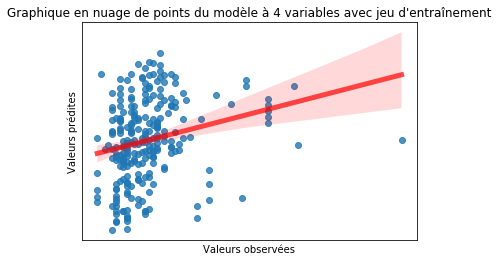


__________________________________________________
Coefficient estimé test:  [[-0.83064241 -0.59997215 -1.14646396  1.51023803]]
MSE test: 120.61
R² test :  0.0656355763651294


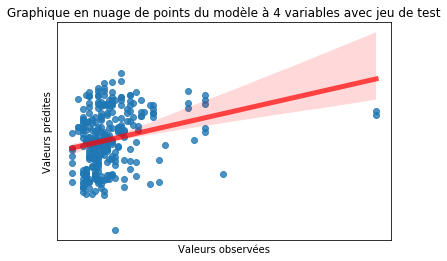


__________________________________________________

Coefficient de régression, R² et MSE de test et d'entraînement du modèle à 3 variables

Coefficient estimé entrainement:  [[-1.05174998 -1.13133682 -0.78475897]]
MSE d'entraînement: 98.80
R² d'entrainement :  0.03822975813454366



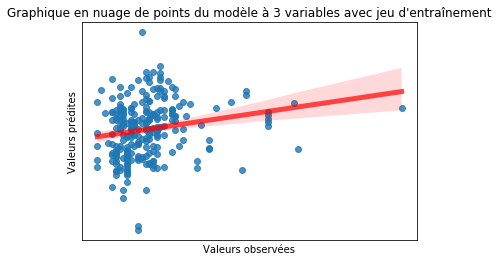


__________________________________________________
Coefficient estimé test:  [[-1.05174998 -1.13133682 -0.78475897]]
MSE test: 124.43
R² test :  0.035997525090895155


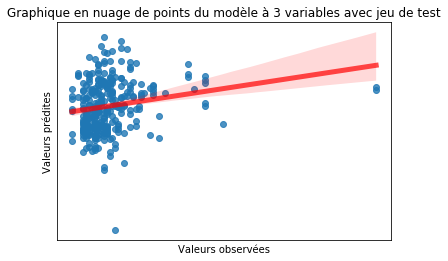


__________________________________________________

Coefficient de régression, R² et MSE de test et d'entraînement du modèle à 2 variables

Coefficient estimé entrainement:  [[-1.19015399 -1.34785478]]
MSE d'entraînement: 99.33
R² d'entrainement :  0.033164216240183286



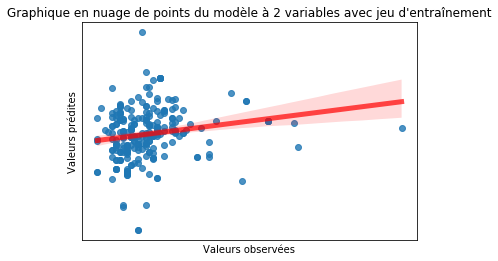


__________________________________________________
Coefficient estimé test:  [[-1.19015399 -1.34785478]]
MSE test: 125.98
R² test :  0.02395926276744631


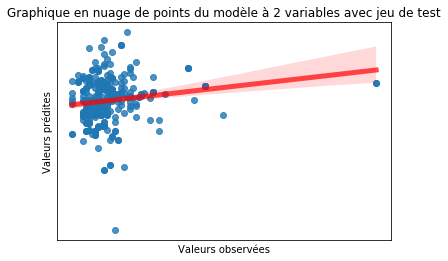


__________________________________________________

Coefficient de régression, R² et MSE de test et d'entraînement du modèle à 1 variable

Coefficient estimé entrainement:  [[-1.18944386]]
MSE d'entraînement: 101.15
R² d'entrainement :  0.015394510328289535



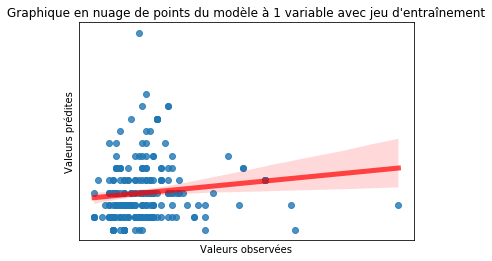


__________________________________________________
Coefficient estimé test:  [[-1.18944386]]
MSE test: 127.00
R² test :  0.016105894710897628


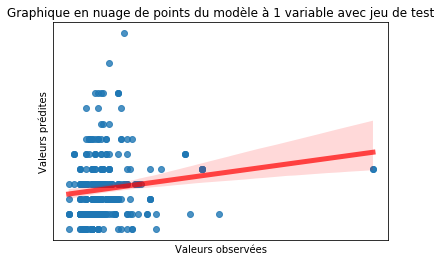

In [10]:
RMSE = np.ones((5,1))
MSE = np.ones((5,1))
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
# Création d'une boucle nous donnant la valeur du coefficient estimé,
# du MSE et d'un graphique en nuage de points pour chacune de nos variables
for dd in range(4,0,-1):
    # Utiliser uniquement une partie des variables à chaque fois
    bestsell_X = Xbest.iloc[:, :dd]
    # Entrainer le modèle avec les données d'entraînements + prédictions et MSE
    # Split du jeu de données
    bestsell_X_train, bestsell_X_test, bestsell_y_train, bestsell_y_test = train_test_split(bestsell_X,ybest, test_size=0.55, random_state=3)
    regr.fit(bestsell_X_train,bestsell_y_train)
    pred_train = regr.predict(bestsell_X_train)
    RMSE[dd] = mean_squared_error(bestsell_y_train, pred_train)
    # Présentation pour chacun de nos modèles
        
    print()
    print("__________________________________________________")
    print()
    if dd>1 : 
        print (color.BOLD+"Coefficient de régression, R² et MSE de test et d'entraînement du modèle à "+str(dd) +" variables"+color.END)
    else :
        print (color.BOLD+"Coefficient de régression, R² et MSE de test et d'entraînement du modèle à "+str(dd) +" variable"+color.END)
    print()
    # Affichage du coefficient
    print('Coefficient estimé entrainement: ', regr.coef_)
    # Affichage du MSE
    print("MSE d'entraînement: %.2f"
      % mean_squared_error(bestsell_y_train, pred_train))
    print("R² d'entrainement : ",regr.score(bestsell_X_train, bestsell_y_train))
    print()
    ### Affichage des graphiques en nuages de points

   # Graphique en nuage de points pour chacun de nos modèles en fonction des valeurs actuelles et celles prédites ENTRAINEMENT
    sns.regplot(x=bestsell_y_train, y= pred_train, line_kws={"color":"r","alpha":0.7,"lw":5})
    # Titres et labels
    if dd>1 : 
        plt.title('Graphique en nuage de points du modèle à '+str(dd)+ " variables avec jeu d'entraînement")
    else :
        plt.title('Graphique en nuage de points du modèle à '+str(dd)+ " variable avec jeu d'entraînement")
    plt.xlabel('Valeurs observées')
    plt.ylabel('Valeurs prédites')
   #  Rendre vide les chiffres de nos axes
    plt.xticks(())
    plt.yticks(())
    plt.show()
    print()
    print("__________________________________________________")
    # Graphique en nuage de points pour chacun de nos modèles en fonction des valeurs actuelles et celles prédites TEST
    pred_test = regr.predict(bestsell_X_test)
    MSE[dd] = mean_squared_error(bestsell_y_test, pred_test)
    sns.regplot(x=bestsell_y_test, y= pred_test, line_kws={"color":"r","alpha":0.7,"lw":5})
    # Titres et labels
    if dd>1 : 
        plt.title('Graphique en nuage de points du modèle à '+str(dd)+ " variables avec jeu de test")
    else :
        plt.title('Graphique en nuage de points du modèle à '+str(dd)+ " variable avec jeu de test")
    plt.xlabel('Valeurs observées')
    plt.ylabel('Valeurs prédites')
   #  Rendre vide les chiffres de nos axes
    plt.xticks(())
    plt.yticks(())
    # Affichage du coefficient
    print('Coefficient estimé test: ', regr.coef_)
    # Affichage du MSE
    print("MSE test: %.2f"
      % mean_squared_error(bestsell_y_test, pred_test))
    print("R² test : ",regr.score(bestsell_X_test, bestsell_y_test))

#  Affichage des graphiques finaux
    plt.show()

Pour chacune de nos modèles, nous avons calculé les coefficients estimés par nos régressions linéaires, l'erreur quadratique moyenne (risque empirique), le R², ainsi qu'un graphique en nuage de points présentant la relation entre les valeurs prédites et observées.

Nous remarquons dans ce cas présent que plus y a de variables, mieux la regression linéaire arrive à prédire les valeurs du prix des livres. <br> En effet, plus il y a de variables, plus l'erreur quadratique moyenne de nos modèles diminue. Pour rappel, l'un des critères de sélection d'un modèle de regression linéaire se fait par rapport à la valeur du MSE, plus celui-ci est bas, mieux c'est, le MSE étant la mesure la moyenne des carrés des erreurs, c'est-à-dire la différence quadratique moyenne entre les valeurs estimées et la valeur réelle.Ce constat n'est évidemment pas général, il arrive des cas ou l'ajout de variables à un modèle fait augmenter la valeur du MSE. <br> <br>
De plus, pour la suite de nos interprétations, nous prendrons le modèle 4 variables comme référence, car il s'agit du meilleur modèle. Ainsi les coefficients estimés nous informe que la note des utilisateurs, le nombre de commentaires et l'année de parution des livres ont une relation négative sur le prix. Seul le fait qu'un livre ne soit pas un livre de fiction à une relation positive avec notre variable à prédire. L'ordre d'importance des variables est le suivant : <br> 1/ Le genre non fiction <br> 2/ Le nombre de commentaires <br> 3/ la note des utilisateurs <br> 4/ l'année de parution 
<br> <br>
Enfin, pour l'ensemble de nos modèles, la regression linéaire ne semble pas être adapté. les R² sont extremement faible.Nous sommes en situation de sous-ajustement.Les prédictions concordent très peu avec les vraies valeur de prix. Normalement, les points de nos graphiques en nuage de points auraient du être plus ou mieux confondut avec la droite de regression. Ceci s'explique en partie par le fait que nous n'avons pas inclu le prix dans nos variables predictives (le modèle aurait était parfait sinon),le trop peu de données / variables dont nous disposons pour prédire le prix des livres ou encore le fait que nous essayons de représenter des données qui n'ont pas de relation linéaire sur un modèle linéaire.

Nous remarquons que les graphiques  corrélant la prédiction et les valeurs initiales sont plus ou moins visuellement les mêmes qu'avec notre modèle avec le jeu d'entrainement. Les MSE sont légérement plus élevés, l'ordre des coefficients reste le même.

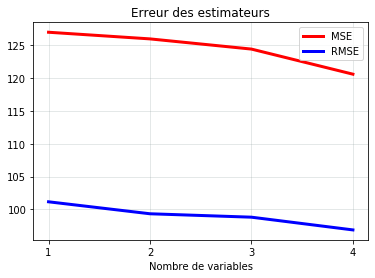

In [11]:
# Comparaison du MSE et de l'ERM pour chacune des variables
plt.plot(range(1,5), MSE[1:5], color='red', linewidth=3,label="MSE")
plt.plot(range(1,5), RMSE[1:5], color='blue', linewidth=3,label="RMSE")
plt.title('Erreur des estimateurs')
plt.xlabel('Nombre de variables')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xticks(range(1,5))
plt.legend(loc ="upper right")
plt.show()


Le graphique ci-dessus nous montre le MSE (prédiction sur le jeux de données de test) et la RMSE (risque empirique). Nous remarquons que le risque empirique est toujours plus faible que le MSE, ce qui semble normal (tester un modèle son jeu de données d'entraînement donne en général de meilleurs résultats). Enfin, le modèle à 4 variables est celui que nous selectionnons pour les 2 erreur des estimateurs, car c'est là ou les 2 métriques sont les plus faible.
NB : celà ne signifie pas qu'un modèle avec un grand nombre de variables va toujours avoir des eurreur faibles. Il peut y avoir des variables non informatives ou trop corrélées entre elles qui vont avoir pour effet de réduire la précision du modèle. Ici pour nos variables contiennent de l'information sur le prix des lives.

comme nous manipulons des modèles à plusieurs variables, nous introduirons ici le critère de pénalisation. Il s'agit d'une version corrigée du risque empirique permettant d'éviter le sur-ajustement et de se rapprocher de l'erreur quadratique moyenne du jeu de test grâce à l'ajout d'une pénalisation.

In [19]:
RMSE

array([[  1.        ],
       [101.150869  ],
       [ 99.32534476],
       [ 98.80494956],
       [ 96.86389236]])

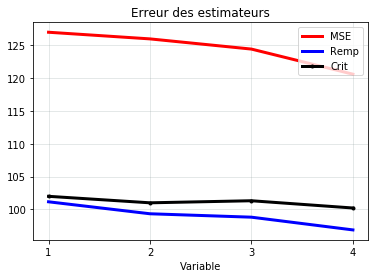

In [12]:
# Calcul du crit
a = [[0, 1, 2, 3,4]]
 # Calcul de sigma pour le critère pénalisé
sigma = bestsell_y_train.std()
Crit = RMSE + 2*(sigma**2)[0]*np.transpose(a)/len(bestsell_y_train)
# Comparaison du MSE et de l'ERM pour chacune des variables
plt.plot(range(1,5), MSE[1:], color='red', linewidth=3,label="MSE")
plt.plot(range(1,5), RMSE[1:], color='blue', linewidth=3,label="Remp")
plt.plot(range(1,5), Crit[1:], '.-', color='black', linewidth=3,label="Crit")
plt.title('Erreur des estimateurs')
plt.xlabel('Variable')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xticks(range(1,5))
plt.legend(loc ="upper right")
plt.show()


On constate que quelue soit la métrique, le modèle à 4 variables démeur le meilleur

In [34]:
# Randomiser les variables
col = [0,1,3,2]
Xbest=Xbest[:,col]
# Set of parameter values to be explored
parameters = {'dim':range(1,5)}
# Learning strategy to assess
linreg = linear_model.LinearRegression()

## Classification

Un modèle de classification est un modèle qui classe chaque instance d’un jeu de données dans une catégorie. On distingue deux grands types de modèle de classification : \
Binaire : il n’y a que deux catégories possibles, par exemple : la potabilité d’un échantillon d’eau (potable ou non potable). \
Multi-classe : il y a au moins trois catégories, par exemple : la météo un jour donné (pluie, soleil ou neige).

### Regression logistique sur dataset amazon

Ici La régression logistique est est du type binaire car nous cherchons à classer les livre en fiction ou nous fiction. 

La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives et/ou quantitatives Xi et une variable expliquée dite catégoriaelle Y. Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. 
Un modèle de régression logistique permet aussi de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression. Ce résultat varie toujours entre 0 et 1. Lorsque la valeur prédite est supérieure à un seuil, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure au même seuil, il ne l’est pas.

Ici nous nous concentrons uniquement sur les perfomences d'une régression logistique basique en faisant varier les pourcentages de l'échantillont de test

Les métriques utilisées sont : \
*l'Accuracy* :  qui est le nombre bonne prédiction ( en 0 et en 1) sur le nombre total d'observation \
NB : l'accurary est une bonne métrique uniquement quand la base de données est équilibrées selon les modalité de la variable cibles\
*La précision* : est le nombre d'observations bien prédit pour une classe i sur le nombre d'observations comme etant dans la classe i. la précision est appelée valeur prédictive positive. \
*Le Recall* : est le nombre d'observations bien prédit pour une classe i sur le nombre d'observations de la classe i. le Recall est appelé sensibilité.

In [14]:
testratio=[0.2, 0.25,0.3, 0.35,0.4,0.5]
from sklearn.metrics import confusion_matrix
Xd=Bestsellersdum[["User Rating","Reviews","Price","Year","Genre_Non Fiction"]]
X2 = Xd.drop('Genre_Non Fiction', axis = 1)
y2 = Xd['Genre_Non Fiction']
for x in testratio :
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = x, random_state = 3)
    logisticregression = LogisticRegression()
    logisticregression.fit(X_train, y_train)
    y_pred = logisticregression.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("_______________________________")
    print("Test-size ="+str(x))
    print()
    print(cm)
    print()
    a = cm.shape
    corrPred = 0
    falsePred = 0

    for row in range(a[0]):
        for c in range(a[1]):
            if row == c:
                corrPred +=cm[row,c]
            else:
                falsePred += cm[row,c]
    print('Correct predictions: ', corrPred)
    print('False predictions', falsePred)
    print ('Accuracy : ', corrPred/(cm.sum()))
    print ('Précision : ',  precision_score(y_test,y_pred, average='macro'))
    print ('Recall : ', recall_score(y_test,y_pred, average='macro'))
    print()

_______________________________
Test-size =0.2

[[15 26]
 [18 51]]

Correct predictions:  66
False predictions 44
Accuracy :  0.6
Précision :  0.5584415584415584
Recall :  0.5524920466595971

_______________________________
Test-size =0.25

[[20 34]
 [18 66]]

Correct predictions:  86
False predictions 52
Accuracy :  0.6231884057971014
Précision :  0.5931578947368421
Recall :  0.578042328042328

_______________________________
Test-size =0.3

[[27 40]
 [21 77]]

Correct predictions:  104
False predictions 61
Accuracy :  0.6303030303030303
Précision :  0.610309829059829
Recall :  0.5943496801705757

_______________________________
Test-size =0.35

[[34 51]
 [22 86]]

Correct predictions:  120
False predictions 73
Accuracy :  0.6217616580310881
Précision :  0.6174400417101147
Recall :  0.5981481481481481

_______________________________
Test-size =0.4

[[38 57]
 [30 95]]

Correct predictions:  133
False predictions 87
Accuracy :  0.6045454545454545
Précision :  0.5919117647058824
Recall 

On remaque que quelque soit la metrique, une taille de l'échantillon de test trop basse ou trop élévée entraiment de mauvaise performance,
on pourrait donc préconiser d'utiliser une taille d'échantillon de test comprise entre 30 et 35 pourcent

Ici nous nous concentrons uniquement sur les perfomences d'une régression logistique basique en faisant varier le nombre de découpage dans la cross validation

In [16]:
# Cross validation
# 10-fold cross-validation with logistic regression
FoldNb = [2, 3, 5, 10, 15,20]
for x in FoldNb :
    skfold = StratifiedKFold(n_splits=x)
    model_skfold = LogisticRegression()
    scores_accuracy = cross_val_score(model_skfold, X2, y2, cv=x, scoring='accuracy')
    scores_recall = cross_val_score(model_skfold, X2, y2, cv=x, scoring='recall')
    scores_precision = cross_val_score(model_skfold, X2, y2, cv=x, scoring='precision')
    print(str(x)+'-fold cross-validation results:')
    print(model_skfold.__class__.__name__+" Moyenne Accuracy is %2.3f" % scores_accuracy.mean())
    print(model_skfold.__class__.__name__+" Moyenne Recall is %2.3f" % scores_recall.mean())
    print(model_skfold.__class__.__name__+" Moyenne Précision is %2.3f" % scores_precision.mean())
    print()
    

2-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.645
LogisticRegression Moyenne Recall is 0.774
LogisticRegression Moyenne Précision is 0.661

3-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.626
LogisticRegression Moyenne Recall is 0.790
LogisticRegression Moyenne Précision is 0.634

5-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.625
LogisticRegression Moyenne Recall is 0.787
LogisticRegression Moyenne Précision is 0.635

10-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.625
LogisticRegression Moyenne Recall is 0.781
LogisticRegression Moyenne Précision is 0.637

15-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.620
LogisticRegression Moyenne Recall is 0.790
LogisticRegression Moyenne Précision is 0.630

20-fold cross-validation results:
LogisticRegression Moyenne Accuracy is 0.622
LogisticRegression Moyenne Recall is 0.793
LogisticRegression Moyenne Précision

Seul le recall tant à etre de plus en plus lévé pour le nombre grandissant de fold dans la cross validation \
quant à l'accuracy, il indique qu'un nombre faible de fold est satisfaisant \
concernant la précision, il faut un nombre plutot moyen, environ 10 \ 
il convient donc dée dire qu'il faut choisir un nombre de fold en fonction des objectifs et de la métrique utilisée

# Data Set Crédit card

Pour le data set credit card nous avons souhaité déterminer les performence de l'acp en terme de reduction de diment pour un but de clustering en comparant la base issue de l'acp à la base initiale selon les performence du GMM

##Description des données

In [19]:
Credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [50]:
Credit.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [104]:
Credit['MINIMUM_PAYMENTS'] = Credit['MINIMUM_PAYMENTS'].fillna(Credit['MINIMUM_PAYMENTS'].median())
Credit['CREDIT_LIMIT'] = Credit['CREDIT_LIMIT'].fillna(Credit['CREDIT_LIMIT'].mean())
Credit = Credit.drop('CUST_ID', axis=1)
Credit.shape

(8950, 17)

In [52]:
Credit.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## PCA

L'ACP  est un algorithme de réduction de dimension 
c'est une réduction de la dimensionnalité linéaire à l'aide de la décomposition par valeur propre des données pour les projeter dans un espace de dimension inférieure
L'ACP est utilisée pour décomposer un ensemble de données multivariées en un ensemble de composantes orthogonales successives qui expliquent une quantité maximale de variance Pour ce faire il comporte un ensemble d'argment qu'il faut bien calibrer pour avoir les meilleurs résultat

--- svd_solver : est une rourine algbrique qui permet un calcul rapide des valeurs propres et des vecteurs propres

    - Auto : Le solveur est automatiquement sélectionné comme suit : si les données d'entrée sont supérieures à 500x500 et que le nombre de composants à extraire est inférieur à 80% de la plus petite dimension des données, alors la méthode "randomized" la plus efficace est activée . Sinon, le SVD "full" est calculé et éventuellement tronqué par la suite.
    - full : Avec full, la selection des composant se fait après leur traitement 
    - Arpack : ici, les composants sont tronqué à n_composant avant le calcule des valeurs et vecteurs propres


l'ACP centre mais ne met pas à l'échelle les données d'entrée pour chaque entité avant d'appliquer le svd_solver. Le paramètre optionnel whiten=Truepermet de projeter les données sur l'espace singulier tout en mettant à l'échelle chaque composante à la variance unitaire.

NB : La selection du nombre de composant en peut se faire de 2 manieres, soit en indiquant directeur le nombre de composant à retenir soit en precision le pourcentage de variance expliquée à  atteindre.
Ici nous ne considérons pas l'effet de la selection des variables 

Ici nous décidons d'évaluer l'acp sur la quantité de variance expliquée

In [105]:
var_ratio={}
scor = {}
svd_solver = ["auto", "full", "arpack", "randomized"]
whiten = ["False","True"]
for i in svd_solver : 
    for j in whiten : 
        pc=PCA( svd_solver=i, whiten=j)
        cr_pca=pc.fit(Credit)
        var_ratio[str(i)+"_"+str(j)]=sum(cr_pca.explained_variance_)

var_ratio

{'auto_False': 43932616.11853713,
 'auto_True': 43932616.11853713,
 'full_False': 43932616.11853713,
 'full_True': 43932616.11853713,
 'arpack_False': 43932616.11187386,
 'arpack_True': 43932616.111873865,
 'randomized_False': 43932616.11853712,
 'randomized_True': 43932616.11853711}

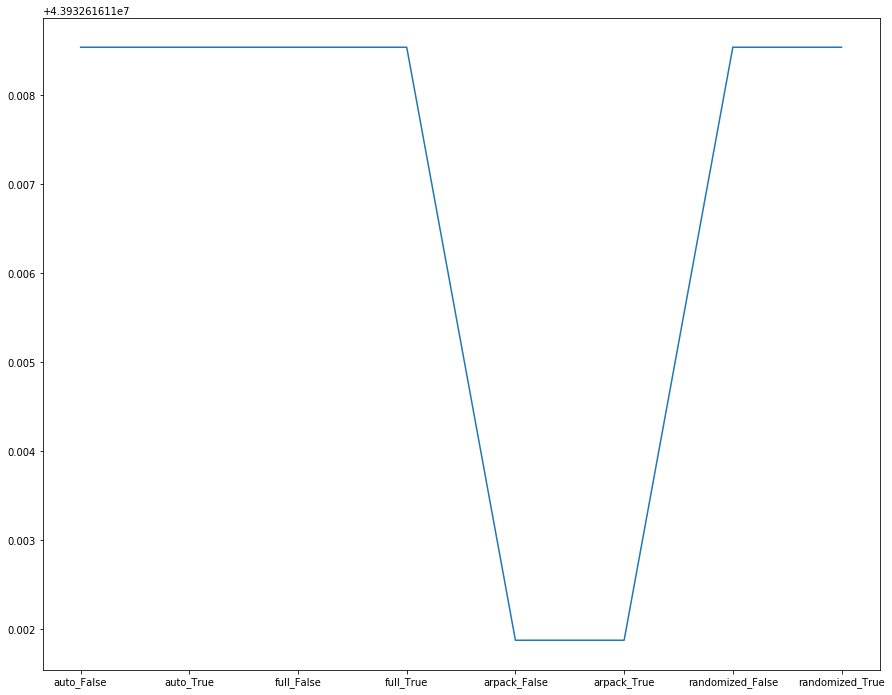

In [24]:
scorr = pd.DataFrame(list(var_ratio.items()),columns=['combi', 'score'])
bars = scorr["combi"]
y_pos = np.arange(len(bars))

fig = plt.figure(1, figsize=(15, 12))
plt.plot(y_pos, scorr['score'])
plt.xticks(y_pos, bars)

plt.show()

Le solver arpack donne les resultats les plus bas.
Nous décidons donc prendre pour la suite la combinaison auto en solver et False en Whiten

In [ ]:
Pour la suite nous gardons un nombre de composant qui nous garantie 99% de la variance des données

In [106]:
pc=PCA(0.99, svd_solver="auto", whiten="False")
Cpc = pc.fit(Credit)
Credit_t = pc.fit_transform(Credit)
Credit_t.shape

(8950, 7)

Donc avec 7 composants nous avant 99% de la variance expliquée

### GMM

Un modèle de mélange gaussien est un modèle probabiliste qui suppose que tous les points de données sont générés à partir d'un mélange d'un nombre fini de distributions gaussiennes avec des paramètres inconnus. On peut considérer les modèles de mélange comme généralisant le regroupement de k-means pour incorporer des informations sur la structure de covariance des données ainsi que sur les centres des Gaussiens latents

Représentation d'une distribution de probabilité d'un modèle de mélange gaussien. Le GMM permet d'estimer les paramètres d'une distribution de mélange gaussienne.

--- n_components : Le nombre de composants du mélange.
    
    
--- covariance_type : 

    - full : chaque composante a sa propre matrice de covariance générale
    - Tied :  tous les composants partagent la même matrice de covariance générale
    - diag :  chaque composante a sa propre matrice de covariance diagonale
    - spherical : chaque composant a sa propre variance unique
    
--- init_params : La méthode utilisée pour initialiser les poids, les moyennes et les précisions.

    - kmeans : les responsabilités sont initialisées à l'aide de kmeans  
    - random : les responsabilités sont initialisées de manière aléatoire

Ici Les métriques utilisées pour évaluer le GMM sont :
-    silhouette_score : Le coefficient de silhouette est calculé en utilisant la distance moyenne intra-cluster (a) et la distance moyenne du cluster le plus proche (b) pour chaque échantillon. Le coefficient de silhouette pour un échantillon est . Pour clarifier, est la distance entre un échantillon et la grappe la plus proche dont l'échantillon ne fait pas partie. Notez que le coefficient de silhouette n'est défini que si le nombre d'étiquettes l'est. (b - a) / max(a, b)b2 <= n_labels <= n_samples - 1.

La meilleure valeur est 1 et la pire valeur est -1. Les valeurs proches de 0 indiquent des clusters qui se chevauchent. Les valeurs négatives indiquent généralement qu'un échantillon a été attribué au mauvais cluster, car un cluster différent est plus similaire.

Ici nous décidons de liniter le nombre de cluster à 7 

## GMM  sur données Globale

In [107]:
dt_sih = pd.DataFrame()
covariance_type = ["full", "tied", "diag", "spherical"]
init_params = ["kmeans", "random"]
n_cluster = range(2,8)
bsil = -10
for i in n_cluster:
    for j in covariance_type :
        for h in init_params : 
            gmm = GaussianMixture(n_components=i, covariance_type=j, init_params=h)
            gmm.fit(Credit)
            yh = gmm.predict(Credit)
            sil = silhouette_score(Credit, yh, metric='euclidean')
            dt_sih.at[i, j+"_"+h] = sil
            if sil > bsil:
                    bsil = sil
                    combs = j+"_"+h
                    n_cls = i
                    x_bests = yh

In [108]:
bsil

0.5168904397140681

In [109]:
combs

'tied_kmeans'

In [110]:
n_cls

2

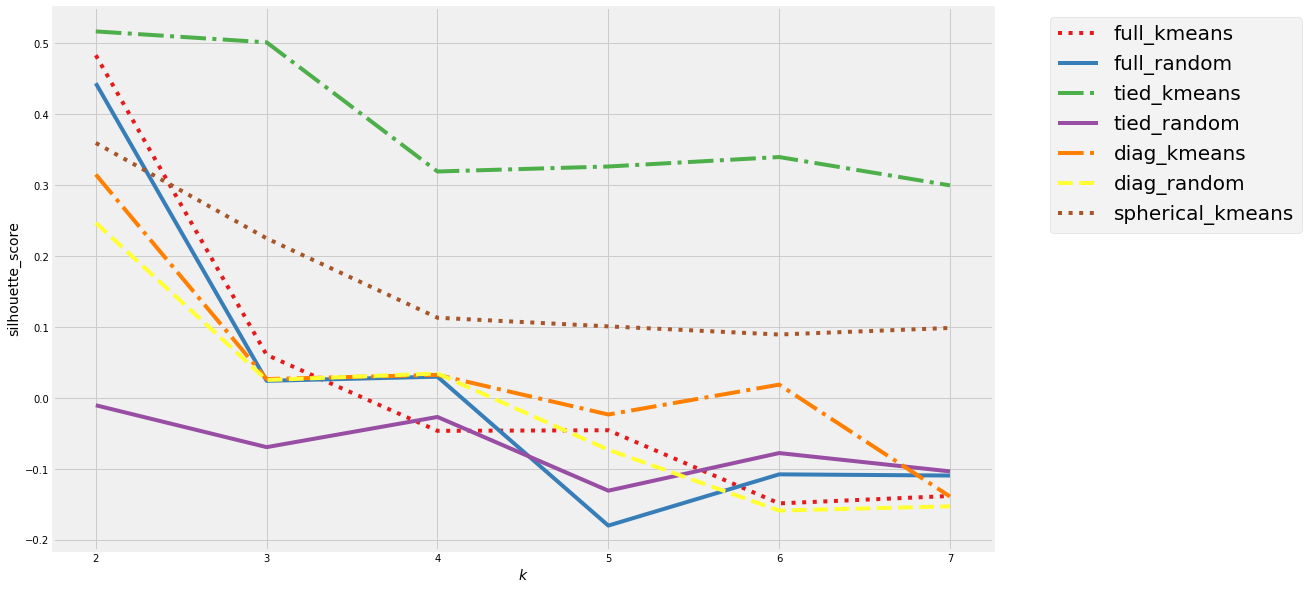

In [111]:
npdat = np.array(dt_sih)
plt.figure(figsize=(15,10))
# to change default colormap
plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
line = [":","-","-.","-","-.","--",":"]
for i in range(7) :
    plt.plot(range(2, 8), npdat[:,i], label=dt_sih.columns[i],linestyle=line[i])
plt.xlabel("$k$", fontsize=14)
plt.ylabel("silhouette_score", fontsize=14)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
plt.show()

La silhouette score est la plus haute avec 2 clusters pour toutes les combinaison de covariance et parametre d'initialisation \
Il faut aussi noter que la silhouette score décroit avec le nombre de cluster croissant pour toutes les combinaisons
Le meilleur score est atteint avec 2 cluster, "kmeans" en initilisation et "tied" comme type de covariance.

Nous representons ce regroupement a l'aide des 2 premier axes de l'acp 

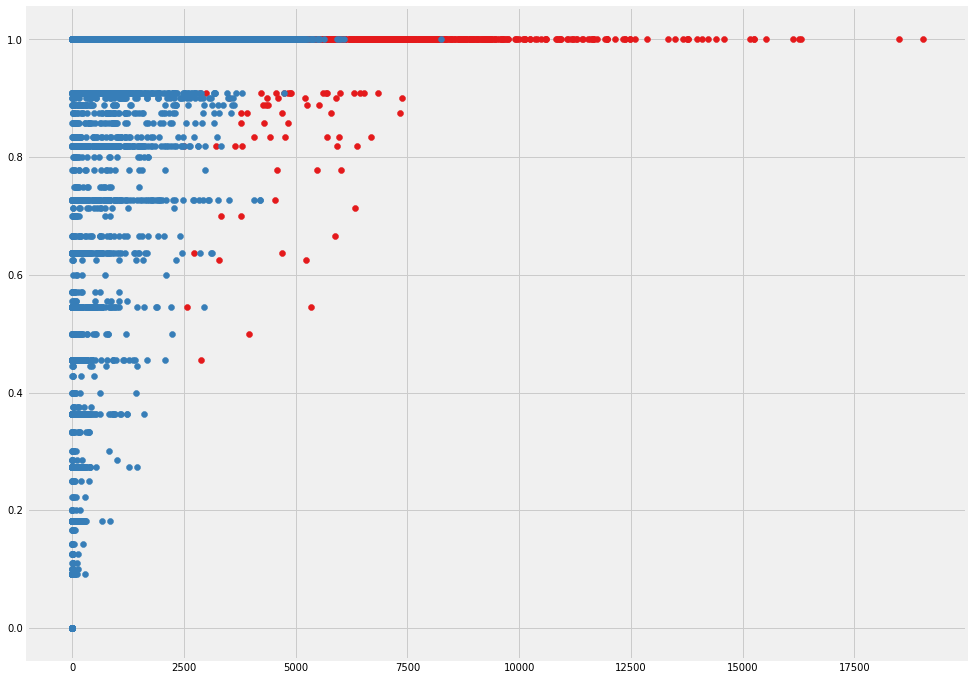

In [112]:
clusters = unique(x_bests)
Credit_np = np.array(Credit)
fig = plt.figure(1, figsize=(15, 12))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(x_bests == cluster)
	# create scatter of these samples
	plt.scatter(Credit_np[row_ix, 0], Credit_np[row_ix, 1])
# show the plot
plt.show()

## GMM sur donnée ACP 

In [114]:
dt_si = pd.DataFrame()
covariance_type = ["full", "tied", "diag", "spherical"]
init_params = ["kmeans", "random"]
n_cluster = range(2,8)
bsil = -10
for i in n_cluster:
    for j in covariance_type :
        for h in init_params : 
            gmm = GaussianMixture(n_components=i, covariance_type=j, init_params=h)
            gmm.fit(Credit_t)
            yh = gmm.predict(Credit_t)
            sil = silhouette_score(Credit_t, yh, metric='euclidean')
            dt_si.at[i, j+"_"+h] = sil
            if sil > bsil:
                    bsil = sil
                    combs = j+"_"+h
                    n_cls = i
                    x_best = yh

In [115]:
n_cls

2

In [116]:
combs

'tied_kmeans'

In [117]:
bsil

0.7642272116195465

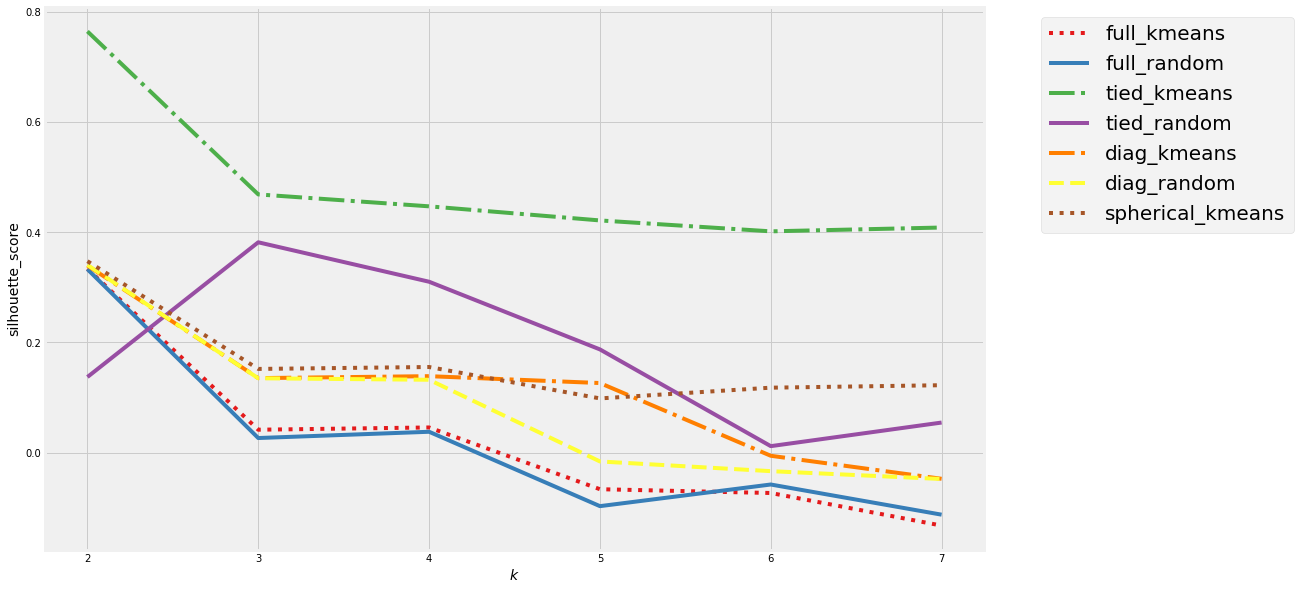

In [118]:
npdat = np.array(dt_si)
plt.figure(figsize=(15,10))
# to change default colormap
plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
line = [":","-","-.","-","-.","--",":"]
for i in range(7) :
    plt.plot(range(2, 8), npdat[:,i], label=dt_sih.columns[i],linestyle=line[i])
plt.xlabel("$k$", fontsize=14)
plt.ylabel("silhouette_score", fontsize=14)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
plt.show()

La silhoutte score est bein meilleure avec les données de l'acp \
IL faut noter que la configuration de GMM qui donne le meilleur score pour deux base est la même ( "tied" et  "kmeans)

de même le score décroit avec le nombre de clusteur (K)

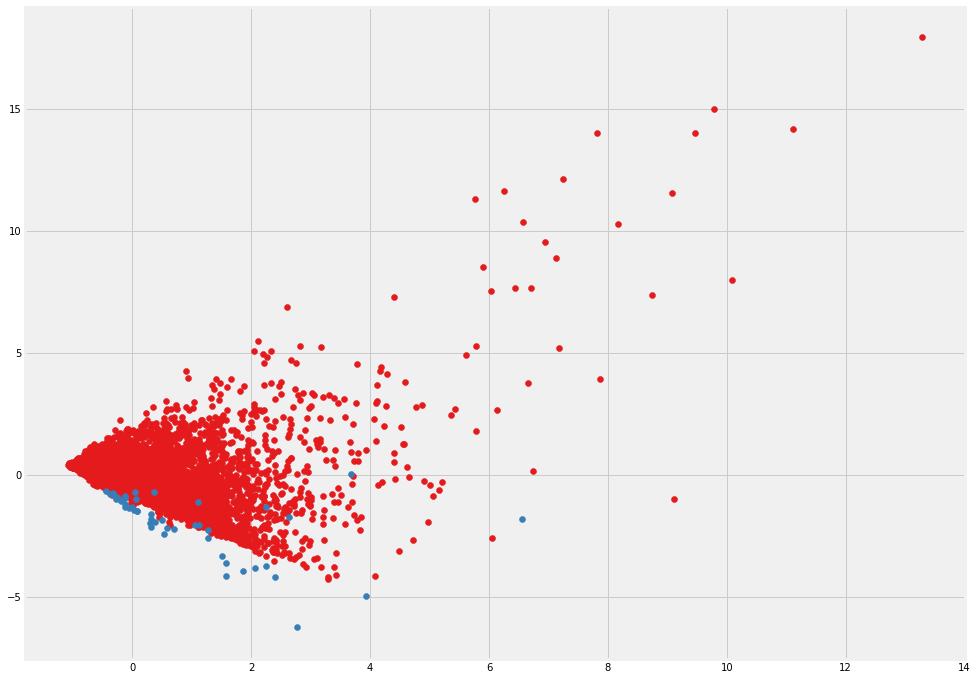

In [119]:
clusters = unique(x_best)
fig = plt.figure(1, figsize=(15, 12))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(x_best == cluster)
	# create scatter of these samples
	plt.scatter(Credit_t[row_ix, 0], Credit_t[row_ix, 1])
# show the plot
plt.show()

### Expérimentation

Nous désrons expérimenter un croisement entre les 2 bases. Pour ce faire nous utiliserons les predictions du GMM sur la base initiale croissées a la base de l'acp pour faire une répresentation graphique

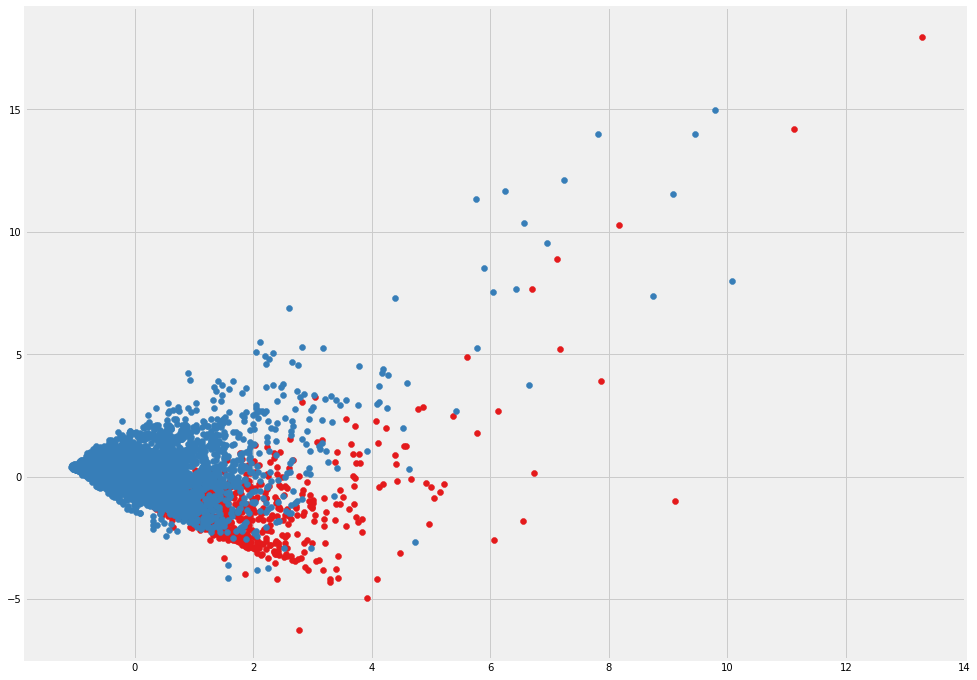

In [121]:
clusters = unique(x_bests)  # Prédiction sur base initiale
fig = plt.figure(1, figsize=(15, 12))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(x_bests == cluster)
	# create scatter of these samples
	plt.scatter(Credit_t[row_ix, 0], Credit_t[row_ix, 1]) # base acp
# show the plot
plt.show()

 *Experience non satisfaisante*

### Conclusion 

Nous pouvons retenir qu'appliquer une reduction dimension via l'acp avant du clustering est très satisfaisant 

# Mobile price

Sur les données mobile nous souhaitons comparer plusieurs algorithmes de classification. pour ce faire nous nous basons sur l'accuracy car notre base données est très bien équilibrée.
Dans un premier temps nous avons explorer la base de donnée.
En second lieu nous avons exécuter les agorithme de classification en 2 phases.
Phase 1 : une comparaison entre les variantes d'un même algorithme, cette comparaison est fait avec une cross validation à 5 fold
Phase 2 : les meilleurs variantes de chaque algorithme sont mis en compétition pour en sortir le meilleur.

Les algorithmes utilsés sont :

    - Decison Tree
    - RandomForest
    - Régression logistique
    - KNN

## Description et cleaning Data

In [47]:
MobileTrain.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [48]:
MobileTrain.shape

(2000, 21)

In [49]:
MobileTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
battery_power    2000 non-null int64
blue             2000 non-null int64
clock_speed      2000 non-null float64
dual_sim         2000 non-null int64
fc               2000 non-null int64
four_g           2000 non-null int64
int_memory       2000 non-null int64
m_dep            2000 non-null float64
mobile_wt        2000 non-null int64
n_cores          2000 non-null int64
pc               2000 non-null int64
px_height        2000 non-null int64
px_width         2000 non-null int64
ram              2000 non-null int64
sc_h             2000 non-null int64
sc_w             2000 non-null int64
talk_time        2000 non-null int64
three_g          2000 non-null int64
touch_screen     2000 non-null int64
wifi             2000 non-null int64
price_range      2000 non-null int64
dtypes: float64(2), int64(19)
memory usage: 328.2 KB


In [50]:
vm_train = MobileTrain.isnull().values.any()
print("Train :",vm_train)

Train : False


In [51]:
# Renommer les variables de la base d'entrainement
MobileTrain = MobileTrain.rename(columns = {'battery_power':'PuissanceBatterie','blue':'Bluetooth','clock_speed':'Verou','dual_sim':'DualSim','fc':'CameraFace',
                                'four_g':'4G','int_memory':'Rom','m_dep':'ProfMobile','mobile_wt':'Poids','pc':'CameraArriere',
                                'px_height':'HateurPixel','px_width':'LageurPixel','ram':'Ram','sc_h':'HateurEcran','sc_w':'LargeurEcran',
                                'talk_time':'TempAppel','three_g': '3G','touch_screen':'Tactile','n_cores':'Core','wifi':'WiFi','price_range':'PlagePrix'})

In [52]:
MobileTrain.columns

Index(['PuissanceBatterie', 'Bluetooth', 'Verou', 'DualSim', 'CameraFace',
       '4G', 'Rom', 'ProfMobile', 'Poids', 'Core', 'CameraArriere',
       'HateurPixel', 'LageurPixel', 'Ram', 'HateurEcran', 'LargeurEcran',
       'TempAppel', '3G', 'Tactile', 'WiFi', 'PlagePrix'],
      dtype='object')

In [53]:
 MobileTrain.PlagePrix.value_counts(normalize=True)

3    0.25
2    0.25
1    0.25
0    0.25
Name: PlagePrix, dtype: float64

In [54]:
meanbyPrice = MobileTrain.groupby('PlagePrix').mean()
meanbyPrice

,PuissanceBatterie,Bluetooth,Verou,DualSim,CameraFace,4G,Rom,ProfMobile,Poids,Core,CameraArriere,HateurPixel,LageurPixel,Ram,HateurEcran,LargeurEcran,TempAppel,3G,Tactile,WiFi
PlagePrix,,,,,,,,,,,,,,,,,,,,
0,1116.902,0.486,1.5502,0.500,4.084,0.518,31.174,0.4902,140.552,4.600,9.574,536.408,1150.270,785.314,12.324,5.682,10.612,0.746,0.524,0.496
1,1228.868,0.490,1.4886,0.510,4.340,0.524,32.116,0.5240,140.510,4.298,9.924,666.892,1251.908,1679.490,12.212,5.544,11.362,0.756,0.522,0.504
2,1228.320,0.486,1.5298,0.498,4.498,0.494,30.920,0.4908,143.614,4.682,10.018,632.284,1234.046,2582.816,12.010,5.714,10.972,0.774,0.470,0.504
3,1379.984,0.518,1.5204,0.530,4.316,0.550,33.976,0.5020,136.320,4.502,10.150,744.848,1369.838,3449.232,12.680,6.128,11.098,0.770,0.496,0.524


In [55]:
stdbyPrice = MobileTrain.groupby('PlagePrix').std()
stdbyPrice

,PuissanceBatterie,Bluetooth,Verou,DualSim,CameraFace,4G,Rom,ProfMobile,Poids,Core,CameraArriere,HateurPixel,LageurPixel,Ram,HateurEcran,LargeurEcran,TempAppel,3G,Tactile,WiFi
PlagePrix,,,,,,,,,,,,,,,,,,,,
0,410.801305,0.500305,0.848941,0.500501,4.183772,0.500176,18.101023,0.288184,36.378319,2.268544,6.095805,372.824164,413.001780,362.755397,4.206949,4.174173,5.397009,0.435734,0.499924,0.500485
1,438.614528,0.500401,0.814479,0.500401,4.499432,0.499924,18.000739,0.286895,35.678956,2.311684,6.124806,441.351209,433.564352,465.850159,4.226913,4.238868,5.570729,0.429923,0.500016,0.500485
2,452.863065,0.500305,0.804404,0.500497,4.347390,0.500465,18.441958,0.286215,34.320326,2.262546,5.952861,445.789232,427.757151,496.211735,4.234355,4.265747,5.433070,0.418658,0.499599,0.500485
3,414.992261,0.500176,0.796450,0.499599,4.332399,0.497992,17.930377,0.291901,34.911994,2.297074,6.085521,483.720179,426.823571,393.019923,4.168976,4.716790,5.443129,0.421254,0.500485,0.499924


## Visualisation

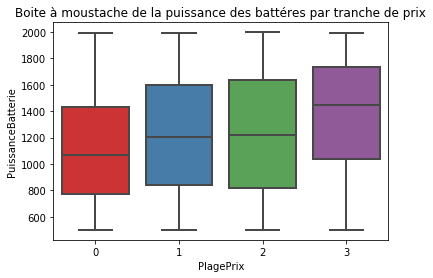

In [56]:
sns.boxplot(x="PlagePrix", y="PuissanceBatterie", data=MobileTrain,palette="Set1",linewidth=2)
plt.title('Boite à moustache de la puissance des battéres par tranche de prix')
plt.show()

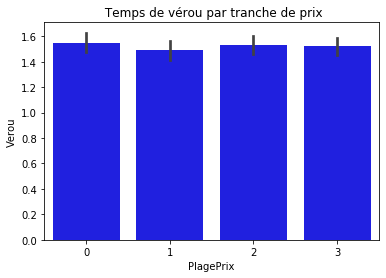

In [57]:
sns.barplot(x="PlagePrix", y="Verou", data=MobileTrain,color="b")
plt.title(' Temps de vérou par tranche de prix')
plt.show()

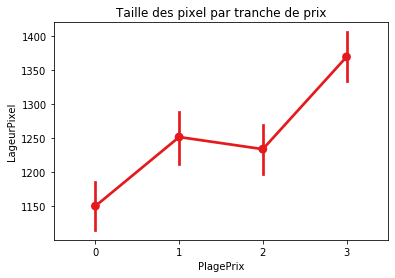

In [58]:
sns.pointplot(x="PlagePrix", y="LageurPixel", data=MobileTrain,linewidth=1.5)
plt.title('Taille des pixel par tranche de prix')
plt.show()

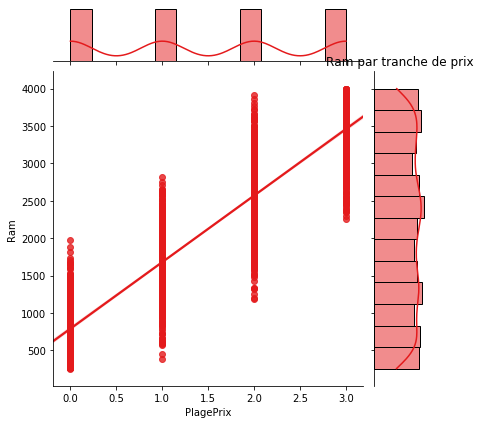

In [59]:
sns.jointplot(x="PlagePrix", y="Ram", data=MobileTrain,kind="reg", truncate=False)
plt.title('Ram par tranche de prix')
plt.show()

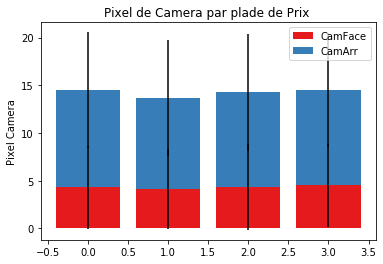

In [60]:
fig, ax = plt.subplots()

labels = MobileTrain.PlagePrix.unique().tolist()
CamFace_means = meanbyPrice.CameraFace.tolist()
CamArr_means = meanbyPrice.CameraArriere.tolist()
CamFace_std = stdbyPrice.CameraFace.tolist()
CamArr_std = stdbyPrice.CameraArriere.tolist()


ax.bar(labels, CamFace_means, yerr=CamFace_std, label='CamFace')
ax.bar(labels, CamArr_means, yerr=CamArr_std, bottom=CamFace_means,
       label='CamArr')

ax.set_ylabel('Pixel Camera')
ax.set_title('Pixel de Camera par plade de Prix ')
ax.legend()

plt.show()

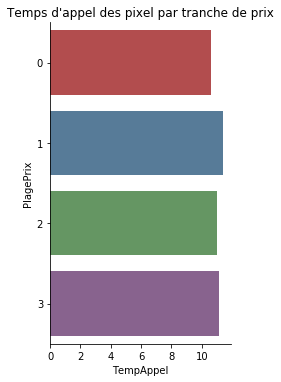

In [61]:
g = sns.catplot(y="PlagePrix", x="TempAppel", data=MobileTrain, saturation=.5,kind="bar", ci=None, aspect=.6,orient="h")
plt.title('Temps d\'appel des pixel par tranche de prix')
plt.show()

## Features Engineering

### Corrélation 

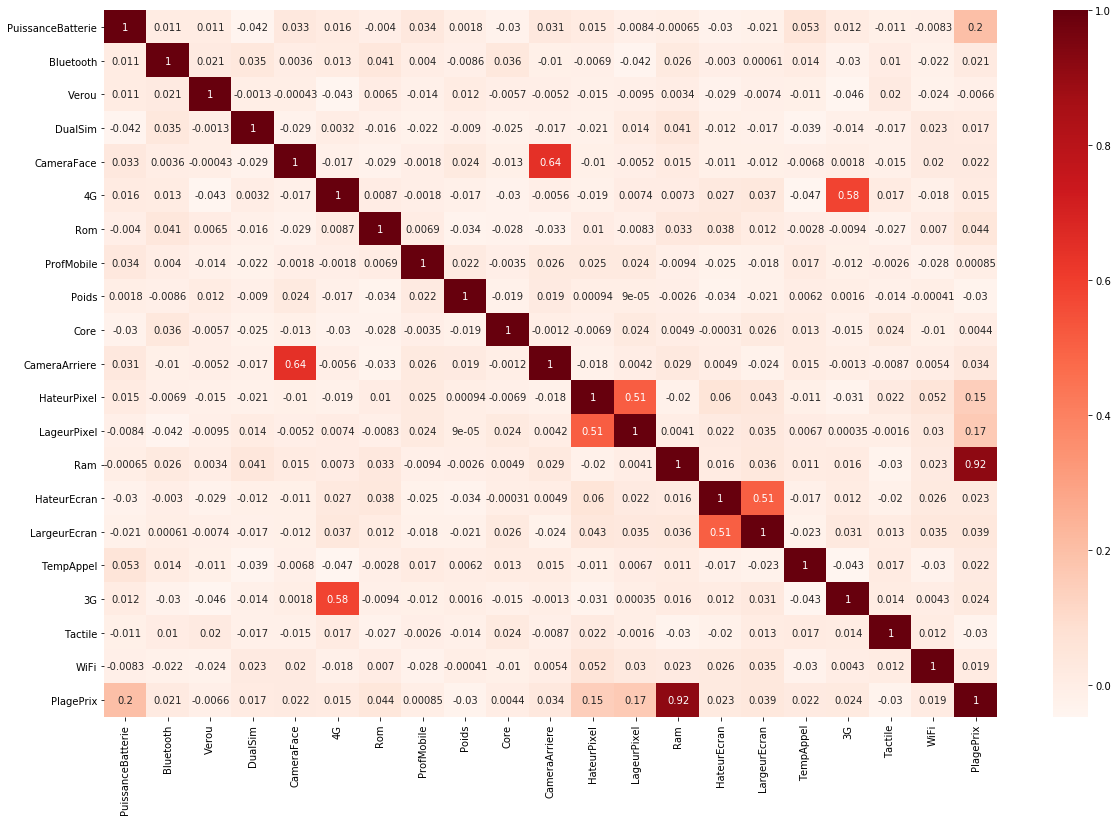

In [62]:
# Corrélation
plt.figure (figsize = (20,13)) 
cor = MobileTrain.corr () 
sns.heatmap(cor, annot = True, cmap = plt.cm.Reds) 
plt.show ()

In [63]:
cor_target = abs (cor ["PlagePrix"])
relevant_features = cor_target [cor_target> 0.1].index.tolist()
relevant_features

['PuissanceBatterie', 'HateurPixel', 'LageurPixel', 'Ram', 'PlagePrix']

In [66]:
ListNonLin=[]
for i in MobileTrain.columns:
    a = scipy.stats.kendalltau(MobileTrain["PlagePrix"],MobileTrain[i])[1]
    if a < 0.05:
        ListNonLin.append(i)
ListNonLin

['PuissanceBatterie', 'Rom', 'HateurPixel', 'LageurPixel', 'Ram', 'PlagePrix']

In [67]:
corFeature = list(set(ListNonLin+relevant_features))
corFeature.remove('PlagePrix')

## Modelisation

In [68]:
X = MobileTrain.drop("PlagePrix", axis=1)
y = MobileTrain['PlagePrix']

In [69]:
liste_variables = X.columns.tolist()
liste_variables

['PuissanceBatterie',
 'Bluetooth',
 'Verou',
 'DualSim',
 'CameraFace',
 '4G',
 'Rom',
 'ProfMobile',
 'Poids',
 'Core',
 'CameraArriere',
 'HateurPixel',
 'LageurPixel',
 'Ram',
 'HateurEcran',
 'LargeurEcran',
 'TempAppel',
 '3G',
 'Tactile',
 'WiFi']

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Pour tous les modèles nous excutons une cross validation avec 5 fold  et comme métrique l'accuracy car nos données sont très bien équilibrées selon la variable plage du prix

### Décision Tree

### Explication des argurments de l'agorithme : Décision Tree
----- Criterion : Pour mesurer la qualité d'une scission. Les critères pris en charge sont «gini» pour l'impureté de Gini et «entropie» pour le gain d'information \
- Gini : il s'agit d'une métrique de fractionnement d'arbre de décision standard. l'impureté de Gini est une mesure de la fréquence à laquelle un élément choisi au hasard dans l'ensemble serait mal étiqueté s'il était étiqueté au hasard en fonction de la  distribution des étiquettes dans le sous-ensemble
             
- Entropy : correspond à la quantité d'information contenue ou délivrée par une source d'information, ainsi on calcule la quantité d'information contenue dans chaque découpage de l'abre
    
----- Splitter : La stratégie utilisée pour choisir la division à chaque nœud. Les stratégies prises en charge sont «meilleures» pour choisir la meilleure division et «aléatoire» pour choisir la meilleure division aléatoire\
- Best : Permet de choisir le nombre de variables qui donne le meilleur resultat dans le découpage du noeuf\
- Random : Choisi le nombre de variable au hasard
    
----- max_depth : La profondeur maximale de l'arbre. le nombre de nœuds

In [74]:
criterion = ["gini", "entropy" ]
splitter = ["best", "random"]
depth = [5,10,15,20]
scordT = {}
for h in depth:
    for i in criterion :
        for j in splitter :
            clf = DecisionTreeClassifier(random_state=0, criterion=i, splitter=j, max_depth=h)
            cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
            agr = str(h)+"_"+i+"_"+j
            scordT[agr] = cv_scores.mean()

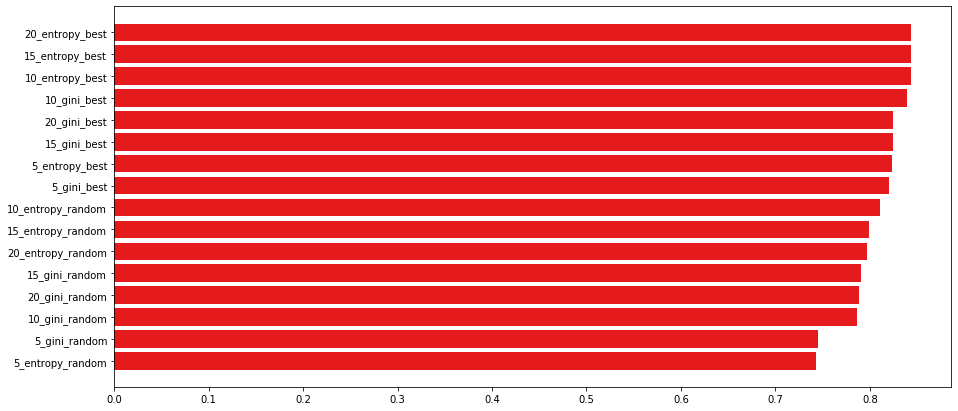

In [75]:
scordTr = pd.DataFrame(list(scordT.items()),columns=['combi', 'score'])
scordTr = scordTr.sort_values(by = 'score')
sdt = scordTr[scordTr["score"]==scordTr["score"].max()]
#x = np.arange(len(scorTr["combi"]))
bars = scordTr["combi"]
y_pos = np.arange(len(bars))

fig = plt.figure(1, figsize=(15, 7))
plt.barh(y_pos, scordTr['score'])
plt.yticks(y_pos, bars)

plt.show()

In [76]:
sdt

,combi,score
6,10_entropy_best,0.844
10,15_entropy_best,0.844
14,20_entropy_best,0.844


In [77]:
Dt = DecisionTreeClassifier(random_state=0, criterion="entropy", splitter="best", max_depth=10).fit(X_train,y_train)

### Random Forest

### Explication des argurments de l'agorithme : Random Forest
----- n_estimators : Le nombre d'arbres à déployer dans l'algorithme

----- Criterion : Pour mesurer la qualité d'une scission. Les critères pris en charge sont «gini» pour l'impureté de Gini et «entropie» pour le gain d'information \
- Gini : il s'agit d'une métrique de fractionnement d'arbre de décision standard. l'impureté de Gini est une mesure de la fréquence à laquelle un élément choisi au hasard dans l'ensemble serait mal étiqueté s'il était étiqueté au hasard en fonction de la  distribution des étiquettes dans le sous-ensemble
             
- Entropy : correspond à la quantité d'information contenue ou délivrée par une source d'information, ainsi on calcule la quantité d'information contenue dans chaque découpage de l'abre

----- max_depth : La profondeur maximale de l'arbre. le nombre de nœuds

In [79]:
criterion = ["gini", "entropy" ]
n_estimators=[50,100,200,300]
depth = [5,10,15,20]
scorrF = {}
for h in depth:
    for i in criterion :
        for j in n_estimators :
            rf = RandomForestClassifier(random_state=0, criterion=i, n_estimators=j, max_depth=h)
            cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
            agr = str(h)+"_"+ str(i) +"_"+ str(j)
            scorrF[agr] = cv_scores.mean()

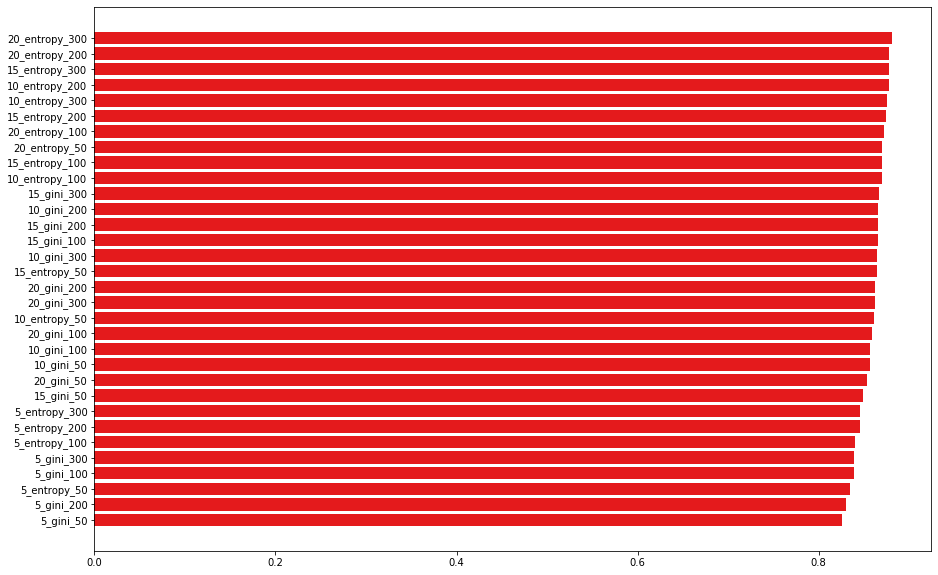

In [80]:
scorrFr = pd.DataFrame(list(scorrF.items()),columns=['combi', 'score'])
scorrFr = scorrFr.sort_values(by = 'score')
srf = scorrFr[scorrFr["score"]==scorrFr["score"].max()]
#x = np.arange(len(scorTr["combi"]))
bars = scorrFr["combi"]
y_pos = np.arange(len(bars))

fig = plt.figure(1, figsize=(15, 10))
plt.barh(y_pos, scorrFr['score'])
plt.yticks(y_pos, bars)

plt.show()

In [81]:
srf 

,combi,score
31,20_entropy_300,0.880667


In [82]:
Rf = RandomForestClassifier(random_state=0, criterion="gini", n_estimators=300, max_depth=10).fit(X_train,y_train)

Text(0.5, 0, 'Relative Importance')

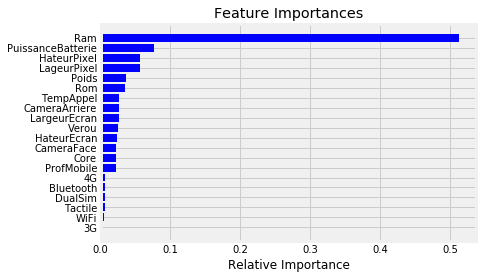

In [83]:
importances = Rf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

### Regression logistique

### Explication des argurments de l'agorithme :  Regression logistique

----- penalty : Utilisé pour spécifier la norme utilisée dans la pénalisation
- l1 : pour resoudre le probleme d'optimisation, la penalité l1 considère la norme du vecteur des coefience de l'équation
- l2 : pour resoudre le probleme d'optimisation, la penalité l2 considère le produit scalaire du vecteur des coefience de l'équation
- elasticnet : pour resoudre le probleme d'optimisation, la penalité elasticnet considère combine les pénalité l1 et l2

----- solver
- liblinear :  utilise un algorithme de descente de coordonnées : Il s’agit ici de minimiser à chaque itération selon une seule coordonnée du vecteur des coeficient, on considère alors une fonction coordonnée par coeficient
- sag :  utilise la descente de gradient moyen stochastique : L'algorithme du gradient stochastique est une méthode de descente de gradient (itérative) utilisée pour la minimisation d'une fonction objectif qui est écrite comme une somme de fonctions différentiables. L'algorithme est itératif et procède donc par améliorations successives. Au point courant, un déplacement est effectué dans la direction opposée au gradient (soustraire une fraction du gradient), de manière à faire décroître la fonction
- saga : est une variante du sag qui prend en charge le non-lissage des données obtenu avec la pénalité l1
- lbfgs : est un algorithme d'optimisation de Broyden – Fletcher – Goldfarb – Shanno à mémoire limitée :la méthode de Broyden-Fletcher-Goldfarb-Shanno (BFGS) est une méthode permettant de résoudre un problème d'optimisation non linéaire sans contraintes. L'idée principale de cette méthode est d'éviter de construire explicitement la matrice hessienne et de construire à la place une approximation de l'inverse de la dérivée seconde de la fonction à minimiser, en analysant les différents gradients successifs


In [84]:
penalty = ["l1", "l2", "elasticnet", "none"]
solver=["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
multi_class = ["auto", "ovr", "multinomial"]
scorrL = {}
for h in penalty:
    for i in solver :
        for j in multi_class :
            lr = LogisticRegression(random_state=0, penalty=h, solver=i, multi_class=j)
            cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
            agr = str(h)+"_"+ str(i) +"_"+ str(j)
            scorrL[agr] = cv_scores.mean()

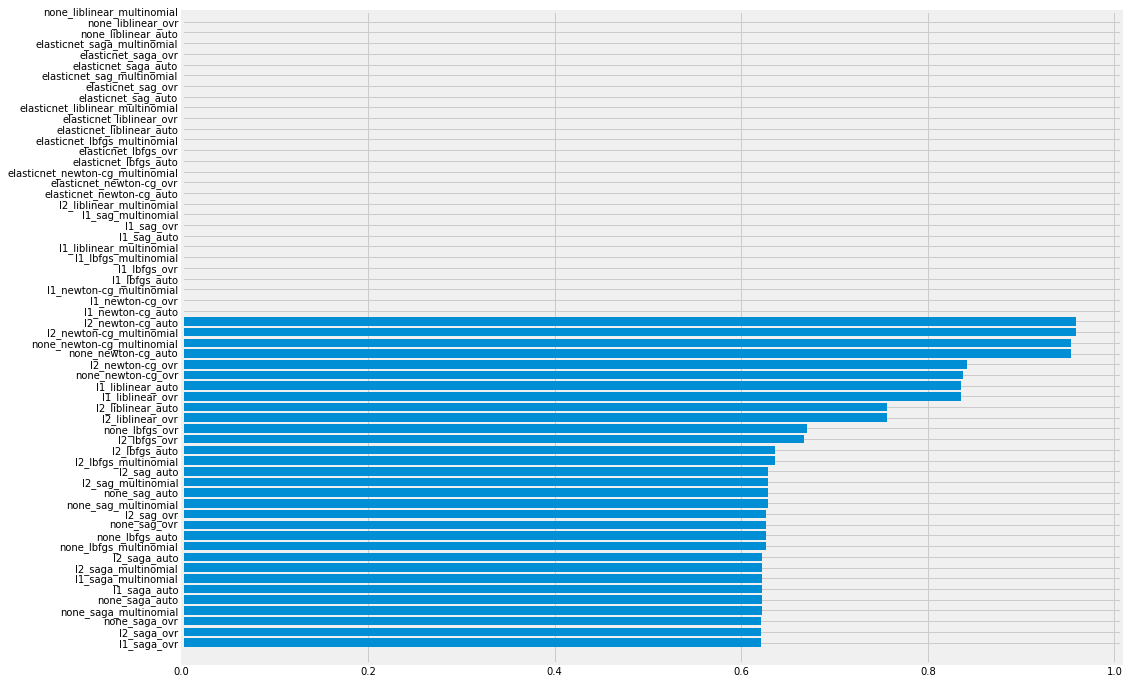

In [85]:
scorrLr = pd.DataFrame(list(scorrL.items()),columns=['combi', 'score'])
scorrLr = scorrLr.sort_values(by = 'score')
srl = scorrLr[scorrLr["score"]==scorrLr["score"].max()]
#x = np.arange(len(scorrLr["combi"]))
bars = scorrLr["combi"]
y_pos = np.arange(len(bars))

fig = plt.figure(1, figsize=(15, 12))
plt.barh(y_pos, scorrLr['score'])
plt.yticks(y_pos, bars)

plt.show()

Dans le gphique nous avons des combinaison pour lesquelles, il n' y a pas de valeur, car avec la régression logistique certains parametres ne sont pas compatible entre eux, en effet : \
Les solveurs 'newton-cg', 'sag' et 'lbfgs' ne supportent que les pénalités de l2 \
 «Elasticnet» n'est supporté que par le solveur «saga» \
 pénalité l1 avec le solveur "sage" doit etres absolument avec l'option "multinomial" de multi_class

In [86]:
srl

,combi,score
17,l2_newton-cg_multinomial,0.959333
15,l2_newton-cg_auto,0.959333


In [87]:
Rl =  LogisticRegression(random_state=0, penalty="l2", solver="newton-cg", multi_class="multinomial").fit(X_train,y_train)

Ici on affiche les coefficients pour chage variable

In [88]:
pd.DataFrame(np.concatenate([Rl.intercept_.reshape(-1,1),
                             Rl.coef_],axis=1),
             index = ["coef0","coef1","coef2","coef3"],
             columns = ["constante"]+list(liste_variables)).T

,coef0,coef1,coef2,coef3
constante,60.551643,23.609923,-17.289338,-66.872228
PuissanceBatterie,-0.012977,-0.003226,0.004632,0.011571
Bluetooth,-0.075811,0.014923,0.132634,-0.071746
Verou,0.055677,-0.015432,-0.156429,0.116184
DualSim,0.078021,0.062400,-0.154806,0.014385
CameraFace,-0.044415,0.011403,0.011065,0.021947
4G,0.040060,0.073957,-0.316142,0.202125
Rom,-0.014682,-0.008993,-0.001013,0.024688
ProfMobile,0.380685,0.374784,-0.295349,-0.460119
Poids,0.027622,0.010827,-0.006174,-0.032274


## KNN 

### Explication des argurments de l'agorithme : KNN
------ n_neighbors : Nombre de voisins considérés


------ weights fonction de poids utilisée dans la prédiction
- uniform : poids uniforme. Tous les points de chaque quartier sont pondérés de manière égale.
- distance : le poids des points est l'inverse de leur distance. dans ce cas, les voisins plus proches d'un point auront une plus grande influence que les voisins qui sont plus éloignés


------ algorithm : Méthode de calcul des distance
- ball_tree : Là où les arbres KD partitionnent les données le long d'axes cartésiens, les arbres à billes partitionnent les données en une série d'hyper-sphères imbriquées. Cela rend la construction d'arbre plus coûteuse que celle de l'arbre KD, mais aboutit à une structure de données qui peut être très efficace sur des données très structurées, même dans des dimensions très élevées
- kd_tree : L'idée de base est que si le point A est très éloigné du point B, et pointe B  est très proche du point C, alors nous savons que les points A et C sont très éloignés, sans avoir à calculer explicitement leur distance
- brute : L'implémentation de recherche de voisins la plus naïve implique le calcul par force brute des distances entre toutes les paires de points de l'ensemble de données: pour N échantillons dans D dimensions, cette approche évolue comme DN^2


In [89]:
n_neighbors  = [3, 5, 10, 20, 35, 50,100]
weights=["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
scorknn = {}
for h in n_neighbors:
    for i in weights :
        for j in algorithm :
            knn = KNeighborsClassifier(n_neighbors=h, weights=i, algorithm=j)
            cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
            agr = str(h)+"_"+ str(i) +"_"+ str(j)
            scorknn[agr] = cv_scores.mean()

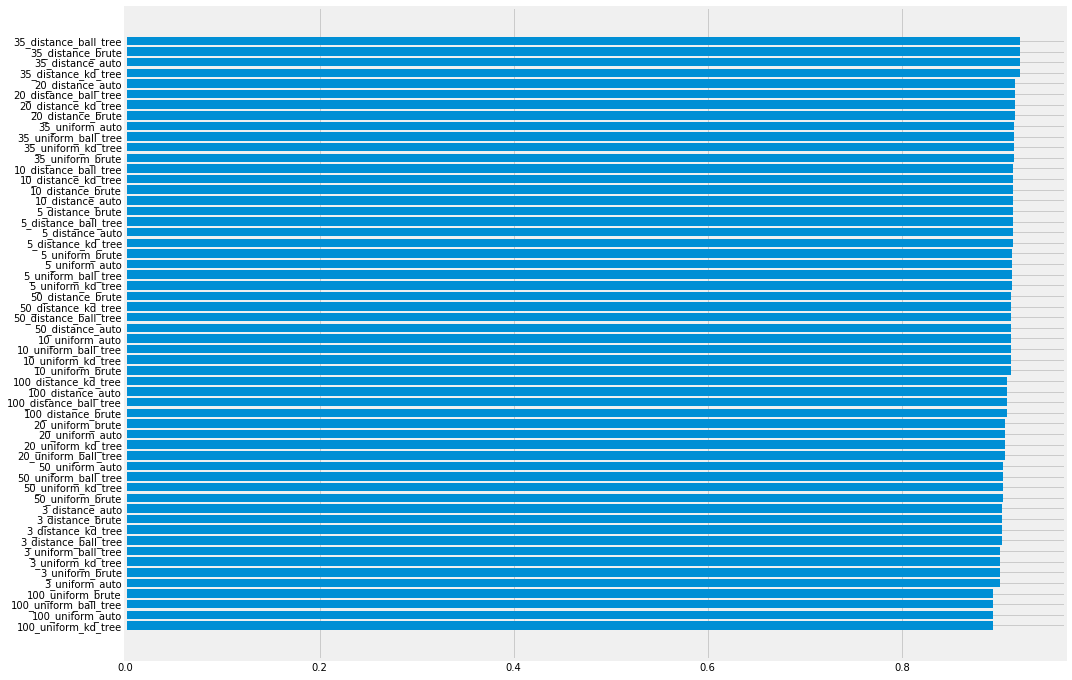

In [90]:
scorknnr = pd.DataFrame(list(scorknn.items()),columns=['combi', 'score'])
scorknnr = scorknnr.sort_values(by = 'score')
sknn = scorknnr[scorknnr["score"]==scorknnr["score"].max()]
#x = np.arange(len(scorknnr["combi"]))
bars = scorknnr["combi"]
y_pos = np.arange(len(bars))

fig = plt.figure(1, figsize=(15, 12))
plt.barh(y_pos, scorknnr['score'])
plt.yticks(y_pos, bars)

plt.show()

In [91]:
sknn

,combi,score
38,35_distance_kd_tree,0.922
36,35_distance_auto,0.922
39,35_distance_brute,0.922
37,35_distance_ball_tree,0.922


In [92]:
KNN =  KNeighborsClassifier(n_neighbors=50, weights="distance", algorithm="kd_tree")

## Les données test sur le meilleur algo : Regression logistique

Au terme de notre expérimentation nous constatons que la  regression logistique en multi_classe est le meilleur algorithme

In [102]:
pred = Rl.predict(X_test)
print("Matrice de confusion",confusion_matrix(y_test,pred), sep="\n \n")
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("Rapport d la classification",classification_report(y_test,pred), sep="\n \n")

Matrice de confusion
 
[[121   3   0   0]
 [  3 103   4   0]
 [  0   4 116   5]
 [  0   0   3 138]]
-------------------------------------------------------------------
-------------------------------------------------------------------
Rapport d la classification
 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.94      0.94      0.94       110
           2       0.94      0.93      0.94       125
           3       0.97      0.98      0.97       141

    accuracy                           0.96       500
   macro avg       0.96      0.95      0.95       500
weighted avg       0.96      0.96      0.96       500

